In [1]:
import sys
sys.path.insert(0,'python')
from classification import *
import pylab as plt
from fastRWpkl import *
from readSent import *
from scipy.ndimage.morphology import binary_dilation as bd
import scipy.ndimage as ndimage
import cPickle as pkl
import numpy as np
import scipy
from scipy import signal
from functools import partial
import multiprocessing
import numpy.ma as ma
from collections import Counter
import cPickle as pkl
import pylab as plt
from scipy.fftpack import dct, idct
import scipy.stats
import matplotlib.gridspec as gridspec
from scipy.stats import gaussian_kde
from scipy import optimize
import matplotlib.patches as patches
from geo_trans import *
%matplotlib inline

In [2]:
modis_sent = parallel_rw_pkl(None,'patch15MS','r')
patch15Sen = parallel_rw_pkl(None, 'patch15Sen', 'r')
cm = parallel_rw_pkl(None, '0510diacm', 'r')[1000:2000,5000:6000]
Sindex = parallel_rw_pkl(None, 'Sindex', 'r')
centers = Sindex

In [3]:
ls L2Adata/R10m/

S2A_USER_AOT_L2A_TL_SGS__20160510T081203_A004605_T50SMG_10m.jp2
S2A_USER_MSI_L2A_TL_SGS__20160510T081203_A004605_T50SMG_B02_10m.jp2
S2A_USER_MSI_L2A_TL_SGS__20160510T081203_A004605_T50SMG_B03_10m.jp2
S2A_USER_MSI_L2A_TL_SGS__20160510T081203_A004605_T50SMG_B04_10m.jp2
S2A_USER_MSI_L2A_TL_SGS__20160510T081203_A004605_T50SMG_B08_10m.jp2
S2A_USER_WVP_L2A_TL_SGS__20160510T081203_A004605_T50SMG_10m.jp2


In [4]:
import glob
band10m = glob.glob('L2Adata/R10m/*B0*')
band20m = glob.glob('L2Adata/R20m/*B1*')

In [5]:
files = band10m + band20m
files.insert(4,band20m[0][:-11]+'B8A_20m.jp2')
files

['L2Adata/R10m/S2A_USER_MSI_L2A_TL_SGS__20160510T081203_A004605_T50SMG_B02_10m.jp2',
 'L2Adata/R10m/S2A_USER_MSI_L2A_TL_SGS__20160510T081203_A004605_T50SMG_B03_10m.jp2',
 'L2Adata/R10m/S2A_USER_MSI_L2A_TL_SGS__20160510T081203_A004605_T50SMG_B04_10m.jp2',
 'L2Adata/R10m/S2A_USER_MSI_L2A_TL_SGS__20160510T081203_A004605_T50SMG_B08_10m.jp2',
 'L2Adata/R20m/S2A_USER_MSI_L2A_TL_SGS__20160510T081203_A004605_T50SMG_B8A_20m.jp2',
 'L2Adata/R20m/S2A_USER_MSI_L2A_TL_SGS__20160510T081203_A004605_T50SMG_B11_20m.jp2',
 'L2Adata/R20m/S2A_USER_MSI_L2A_TL_SGS__20160510T081203_A004605_T50SMG_B12_20m.jp2']

In [6]:
def ScaleExtent(data, shape): # used for unifine different array,

    re = int(shape[0]/(data.shape[0]))

    a = np.repeat(np.repeat(data, re, axis = 1), re, axis =0)
    
    if (re*(data.shape[0])-shape[0]) != 0:
        extended = np.zeros(shape)
        extended[:re*(data.shape[0]),:re*(data.shape[0])] = a
        extended[re*(data.shape[0]):,re*(data.shape[0]):] = a[re*(data.shape[0])-shape[0]:, re*(data.shape[0])-shape[0]]
        return extended
    else:
        return a

In [7]:
sents = []
for i in files:
    data = gdal.Open(i).ReadAsArray()
    sent = ScaleExtent(data, (10980,10980))[1000:2000,5000:6000]
    sents.append(sent)

In [8]:
L2Asen_cut = sents

In [9]:
import multiprocessing
import sys
sys.path.insert(0,'python')
from fastRWpkl import *
import numpy.ma as ma
from readSent import *
from collections import Counter
import cPickle as pkl
from scipy import optimize
from functools import partial
import scipy.ndimage as ndimage
import numpy as np
import scipy
from scipy import signal
import scipy.stats

fhead = 'data/50SMG20165100'

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def applied(L1Csen_cut, L2Asen_cut, modis_sen):
    
    xstd,ystd,angle, sx, sy = 29.696923, 339.96191637, 45.8861022468, -21.8540896067 , 60.2630764605
    xwin,ywin = 100,100
    
    i, j = 1,5
    print 'patch %s%s'%(i,j)
    
    #modis_cut = modis_sent[s1,s2]*0.001
    in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
    patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]
    
    to_regression =[]          
    
    for ii,cx in enumerate(patchx):
        cy = patchy[ii] - 5000
        cx -= 1000
        minx = cx+sx - 50
        maxx = cx+sx + 50
        miny = cy+sy - 50
        maxy = cy+sy + 50

        to_conv1 = L1Csen_cut[max(0, minx): min(1000, maxx), max(0, miny): min(1000, maxy)]
        to_conv2 = L2Asen_cut[max(0, minx): min(1000, maxx), max(0, miny): min(1000, maxy)]
        brdf = modis_sen[cx,cy]*0.001

        if (to_conv1.shape[0]==100) & (to_conv1.shape[1]==100) & (brdf!=np.nan):
            To_conv1 = to_conv1
            To_conv2 = to_conv2
            Brdf = brdf
            
            nanval1 = np.where(~((To_conv1 < 1)&(To_conv1 > 0)))
            To_conv1[nanval1[0], nanval1[1]] = np.nanmean(To_conv1)
            
            nanval2 = np.where(~((To_conv2 < 1)&(To_conv2 > 0)))
            To_conv2[nanval2[0], nanval2[1]] = np.nanmean(To_conv2)
            
            
            gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
            ker = gaus/(gaus.sum())

            s1 = signal.fftconvolve(To_conv1, ker, mode='valid')
            s2 = signal.fftconvolve(To_conv2, ker, mode='valid')
            to_regression.append([s1[0][0],s2[0][0], Brdf])
    
    return np.array(to_regression).T

In [10]:
to_regs = []
names = ('SB2_MB3,SB3_MB4,SB4_MB1,SB8_MB2,SB8a_MB2,SB11_MB6,SB12_MB7').split(',')
for ii,L1Csen_cut in enumerate(patch15Sen):
    reg_data = applied(L1Csen_cut, L2Asen_cut[ii]*0.0001, modis_sent[ii])
    to_regs.append(reg_data)
    print 'Finished %s'%names[ii]

patch 15


/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:60: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:61: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Finished SB2_MB3
patch 15
Finished SB3_MB4
patch 15
Finished SB4_MB1
patch 15
Finished SB8_MB2
patch 15
Finished SB8a_MB2
patch 15
Finished SB11_MB6
patch 15
Finished SB12_MB7


In [11]:
to_regs[0][:3].shape

(3, 365)

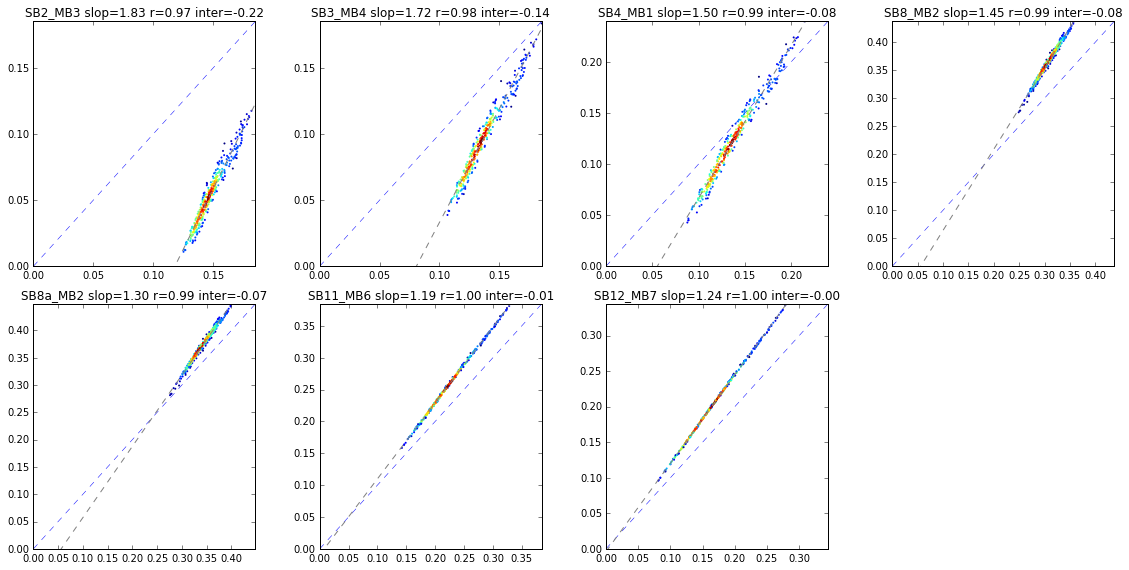

In [12]:
fig = plt.figure
gs = gridspec.GridSpec(2,4)  # generate a grid space
fig = plt.figure(figsize=(16,8))
names = ('SB2_MB3,SB3_MB4,SB4_MB1,SB8_MB2,SB8a_MB2,SB11_MB6,SB12_MB7').split(',')
for i in range(7):
    ax = fig.add_subplot(gs[i])
    
    data = np.array(to_regs[i][:2])
    maxval = np.nanmax(data)
    m = data[0][~(np.isnan(data[1])|np.isnan(data[0]))]
    s = data[1][~(np.isnan(data[1])|np.isnan(data[0]))]
    
    dif = m-s
    sigma = np.nanstd(dif)
    mean = np.nanmean(dif)
    
    Thr_sigma = 3.*sigma
    inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)
    
    m = m[inliers]
    s = s[inliers]

    r = scipy.stats.linregress(m,s) # all of the data composed of mean value and brdf
    fit = np.polyfit(m,s,1)
    fit_fn = np.poly1d(fit)
    #plt.figure(figsize = (7,7))
    xy = np.vstack([m,s])
    z = gaussian_kde(xy)(xy)
    ax.scatter(m,s, c=z, s=4, edgecolor='')
    ax.plot([0,1],[0.,1], '--',linewidth=0.5)
    ax.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
    ax.set_xlim(0, maxval)
    ax.set_ylim(0, maxval)
    ax.set_title('%s'%names[i]+' slop=%.2f'%r.slope+' r=%.2f'%r.rvalue+' inter=%.2f'%r.intercept)
plt.tight_layout()
plt.savefig('img/patch15_regression2.pdf')

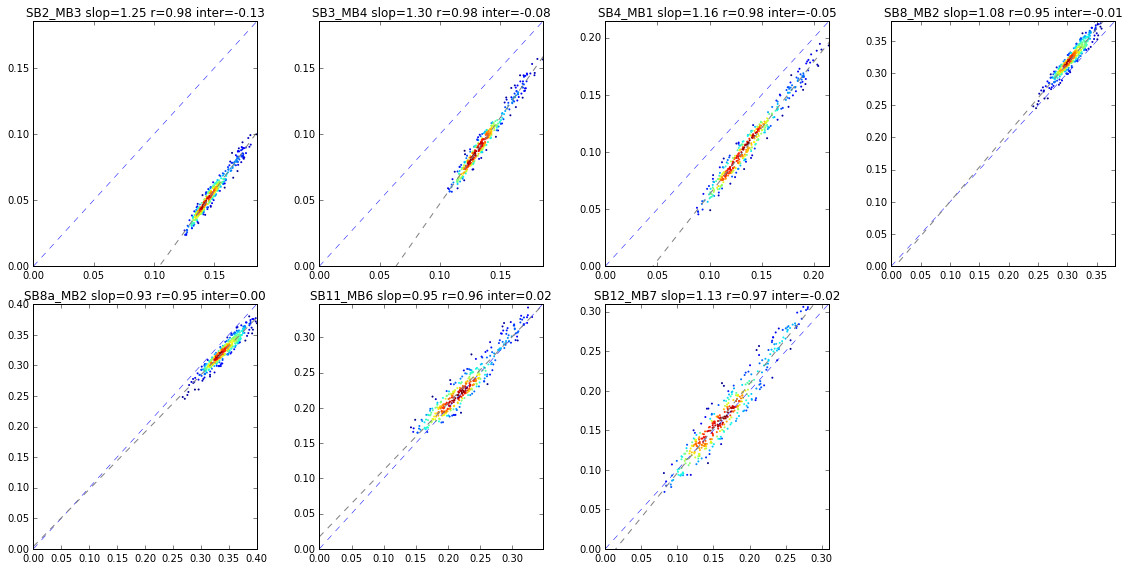

In [13]:
fig = plt.figure
gs = gridspec.GridSpec(2,4)  # generate a grid space
fig = plt.figure(figsize=(16,8))
names = ('SB2_MB3,SB3_MB4,SB4_MB1,SB8_MB2,SB8a_MB2,SB11_MB6,SB12_MB7').split(',')
for i in range(7):
    ax = fig.add_subplot(gs[i])
    
    data = [np.array(to_regs[i][0]), np.array(to_regs[i][-1])]
    maxval = np.nanmax(data)
    m = data[0][~(np.isnan(data[1])|np.isnan(data[0]))]
    s = data[1][~(np.isnan(data[1])|np.isnan(data[0]))]
    
    dif = m-s
    sigma = np.nanstd(dif)
    mean = np.nanmean(dif)
    
    Thr_sigma = 3.*sigma
    inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)
    
    m = m[inliers]
    s = s[inliers]

    r = scipy.stats.linregress(m,s) # all of the data composed of mean value and brdf
    fit = np.polyfit(m,s,1)
    fit_fn = np.poly1d(fit)
    #plt.figure(figsize = (7,7))
    xy = np.vstack([m,s])
    z = gaussian_kde(xy)(xy)
    ax.scatter(m,s, c=z, s=4, edgecolor='')
    ax.plot([0,1],[0.,1], '--',linewidth=0.5)
    ax.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
    ax.set_xlim(0, maxval)
    ax.set_ylim(0, maxval)
    ax.set_title('%s'%names[i]+' slop=%.2f'%r.slope+' r=%.2f'%r.rvalue+' inter=%.2f'%r.intercept)
plt.tight_layout()
plt.savefig('img/patch15_regression2.pdf')

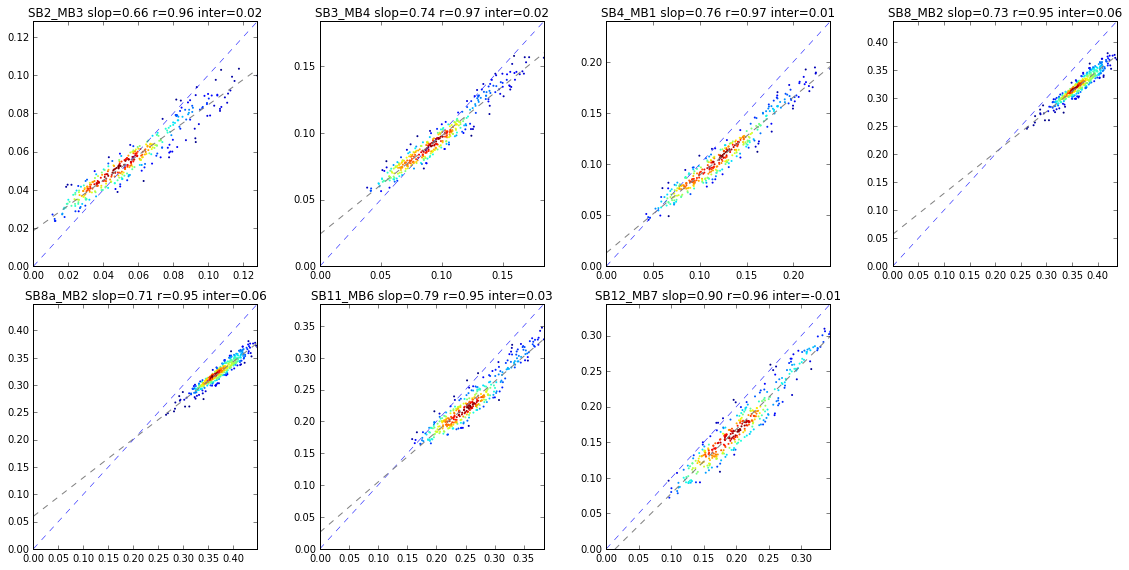

In [14]:
fig = plt.figure
gs = gridspec.GridSpec(2,4)  # generate a grid space
fig = plt.figure(figsize=(16,8))
names = ('SB2_MB3,SB3_MB4,SB4_MB1,SB8_MB2,SB8a_MB2,SB11_MB6,SB12_MB7').split(',')
for i in range(7):
    ax = fig.add_subplot(gs[i])
    
    data = np.array(to_regs[i][1:3])
    maxval = np.nanmax(data)
    m = data[0][~(np.isnan(data[1])|np.isnan(data[0]))]
    s = data[1][~(np.isnan(data[1])|np.isnan(data[0]))]
    
    dif = m-s
    sigma = np.nanstd(dif)
    mean = np.nanmean(dif)
    
    Thr_sigma = 3.*sigma
    inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)
    
    m = m[inliers]
    s = s[inliers]

    r = scipy.stats.linregress(m,s) # all of the data composed of mean value and brdf
    fit = np.polyfit(m,s,1)
    fit_fn = np.poly1d(fit)
    #plt.figure(figsize = (7,7))
    xy = np.vstack([m,s])
    z = gaussian_kde(xy)(xy)
    ax.scatter(m,s, c=z, s=4, edgecolor='')
    ax.plot([0,1],[0.,1], '--',linewidth=0.5)
    ax.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
    ax.set_xlim(0, maxval)
    ax.set_ylim(0, maxval)
    ax.set_title('%s'%names[i]+' slop=%.2f'%r.slope+' r=%.2f'%r.rvalue+' inter=%.2f'%r.intercept)
plt.tight_layout()
plt.savefig('img/patch15_regression2.pdf')

In [ ]:
import multiprocessing
import sys
sys.path.insert(0,'python')
from fastRWpkl import *
import numpy.ma as ma
from readSent import *
from collections import Counter
import cPickle as pkl
from scipy import optimize
from functools import partial
import scipy.ndimage as ndimage
import numpy as np
import scipy
from scipy import signal
import scipy.stats
import tifffile as tiff

fhead = 'data/50SMG20165100'

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(p, winsize):    
    xstd,ystd,angle,sx, sy = p
    xwin,ywin = winsize,winsize
    hlwin = winsize/2
    
    to_regression =[]
    for ii,cx in enumerate(centers[0]):
        cy = centers[1][ii]
        minx = cx+sx - hlwin
        maxx = cx+sx + hlwin
        miny = cy+sy - hlwin
        maxy = cy+sy + hlwin

        to_conv = Sent[max(0, minx): min(10980, maxx), max(0, miny): min(10980, maxy)]
        brdf = modis_sent[cx,cy]*0.001

        if (to_conv.shape[0]==winsize) & (to_conv.shape[1]==winsize) & (brdf!=np.nan):
            To_conv = to_conv
            Brdf = brdf
            nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
            To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)

            
            gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
            ker = gaus/(gaus.sum())

            s = signal.fftconvolve(To_conv, ker, mode='valid')
            to_regression.append([s[0][0], Brdf])
    x,y = np.array(to_regression).T
    nanm = (np.isnan(x))|(np.isnan(y))
    r = scipy.stats.linregress(x[~nanm],y[~nanm])
    costs = abs(1-r.rvalue)
    print 'costs:', costs, 'rvalue: ', r.rvalue, 'slop: ', r.slope, '\n', 'parameters: ', p,'\n'

    return costs
                

def ScaleExtent(data, shape): # used for unifine different array,

    re = int(shape[0]/(data.shape[0]))

    a = np.repeat(np.repeat(data, re, axis = 1), re, axis =0)
    
    if (re*(data.shape[0])-shape[0]) != 0:
        extended = np.zeros(shape)
        extended[:re*(data.shape[0]),:re*(data.shape[0])] = a
        extended[re*(data.shape[0]):,re*(data.shape[0]):] = a[re*(data.shape[0])-shape[0]:, re*(data.shape[0])-shape[0]]
        return extended
    else:
        return a

In [ ]:
Sindex = parallel_rw_pkl(None, 'Sindex', 'r')
centers = Sindex
data = parallel_rw_pkl(None, 'inter_sent%i'%1, 'r')
mask = parallel_rw_pkl(None, 'inter_sentm%i'%1, 'r')
sent = tiff.imread('corband3.tif', key=0)
sent = ScaleExtent(sent, (10980,10980))
cm = parallel_rw_pkl(None, 'newcloudm', 'r')
sent[cm] = np.nan
stm = parallel_rw_pkl(None, 'std_m', 'r')
print 'finshed reading data'
data[mask]=np.nan
modis_sent = np.array(data)
Sent = sent
Stm = stm